<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Installation" data-toc-modified-id="Installation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Installation</a></span></li><li><span><a href="#Tutorial" data-toc-modified-id="Tutorial-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tutorial</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Definitions" data-toc-modified-id="Definitions-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Definitions</a></span></li><li><span><a href="#File-structure" data-toc-modified-id="File-structure-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>File structure</a></span></li><li><span><a href="#Test-data" data-toc-modified-id="Test-data-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Test data</a></span></li></ul></li><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Import libraries</a></span></li></ul></li></ul></div>

# 4D-SXDM tutorial


This notebook introduces basic exploration and preprocessing of 4D-SXDM data obatined on beamline ID01 @ ESRF using the in-house developed library `sxdm`. 

**Requirements**:
* An ESRF single sign-on (SSO)
* Basic knowledge of [Jupyter notebooks](https://jupyter.org/)
* Intermediate knowledge of Python

In [1]:
# %%html

# <style>
#     .container {width:98%}
# <\style>

## Installation

This notebook is meant to be run on the [Jupyter-SLURM hub](https://jupyter-slurm.esrf.fr/). Instructions on how to achieve this are given in the [README](https://gitlab.esrf.fr/id01-science/id01-sxdm-utils/-/blob/main/README.md) of the `sxdm` repository (requires SSO for access). _You should be reading this from within jupyter-slurm!_

To run the notebook a few python dependecies are necessary. To simplify things, these are stored in a virtual environment accessible from jupyter-slurm and maintained by the ID01 staff. To install the virtual environment run the cell below:

In [2]:
# %%bash

# pip3 install --quiet ipykernel
# source /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/bin/activate
# python3 -m ipykernel install --user --name sxdm.slurm

# pip3 install --quiet ipympl
# /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/bin/jupyter nbextension install --py --symlink --user --overwrite ipympl
# /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/bin/jupyter nbextension enable ipympl --user --py

Now refresh the webpage. One this is done, change the active kernel by using the menu bar on the top and clicking on `Kernel > Change kernel > sxdm.slurm`. You are now ready to run the notebook!

## Tutorial

<div class="alert alert-block alert-warning">
<b>Warning:</b> This notebook deals with SXDM data produced by BLISS, the new control system of ESRF. BLISS is still under development and its structure changes relatively often. Some code in this notebook may therefore be out of date (as well as some info/explanations) and not work correctly. If this is the case, please submit an <a href="https://gitlab.esrf.fr/id01-science/id01-sxdm-utils/-/issues">issue</a>
.
</div>

### Introduction

#### Definitions

* _SXDM_: scanning X-ray diffraction microscopy. 
* _4D-SXDM_: A crystal is placed at a Bragg condition so that a Bragg peak is visible on a 2D detector. A nanofocussed beam is then raster scanned across the crystal. At each $(x, y)$ beam position, a detector frame is collected. Thus, a complete 4D-SXDM scan consists of a series of detector frames collected at different nanobeam positions. Namely, one obtains intensity as a function of $(x, y, D_y, D_z)$, where $D_y, D_z$ are the two dimensions of the detector.

4D-SXDM thus refers to SXDM data collected at a single angle, i.e. without rocking the sample. This corresponds to the output of individual `asxdm()` or `dsxdm()` commands run in `BLISS` on ID01.

#### File structure

During an experiment data is saved on the ESRF NICE cluster. Each experiment has a directory tree dedicated to it. For example, the inhouse `blc14269` experiment is located in  `/data/visitor/blc14269/id01/`. A `coo` sub-folder is present in the main folder:

In [27]:
!tree -L 1 /data/visitor/blc14269/id01/

/data/visitor/blc14269/id01/
├── 20221208
├── align
├── anlysis
├── blc14269_id01.h5
├── coo
├── e19090
└── ptpt

6 directories, 1 file


The `coo` folder contains all the data and metadata pertaining the sample named `coo`. It was created by using the `newsample` BLISS command. One should thus run this command every time a sample is changed. 

Within `coo`, one finds several `coo_xxxx` folders:

In [28]:
!tree -L 1 /data/visitor/blc14269/id01/coo

/data/visitor/blc14269/id01/coo
├── blc14269_coo.h5
├── coo_0001
├── coo_0002
├── coo_0003
├── coo_0004
├── coo_0005
├── coo_0006
├── coo_0007
└── coo_0008

8 directories, 1 file


Each folder corresponds to a dataset, and was initialised using the `newdataset` command. Again the idea is to isolate conceptually different scans routines from eachother. For example, two datasets may be two sets of SXDM scans performed at different temperatures.

Finally, within each dataset directory there will be a folder for each scan performed. For example, taking dataset `coo_0002`:

In [29]:
!tree -L 2 /data/visitor/blc14269/id01/coo/coo_0002

/data/visitor/blc14269/id01/coo/coo_0002
├── blc14269-coo-0002.h5
├── coo_0002.h5
├── scan0001
│   ├── mpxgaas_0000_accframe.edf
│   └── mpxgaas_0000.h5
├── scan0002
│   ├── mpxgaas_0000_accframe.edf
│   └── mpxgaas_0000.h5
└── scan0003
    ├── mpxgaas_0000_accframe.edf
    └── mpxgaas_0000.h5

3 directories, 8 files


Everytime one enters one of these subdirectories, an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) (`.h5`) file is present. Indeed there is one even at the very top of the directory tree, above the `coo` directory:

In [30]:
%ls -lh /data/visitor/blc14269/id01/

total 107K
drwxr-x---  2 root     id01 4.0K Dec  5 16:00 20221208/
drwxr-xr-- 13 opid01   id01 4.0K Dec 11 14:40 align/
drwxr-xr--  3 zatterin id01 4.0K Feb  1 10:48 anlysis/
-rw-r--r--  1 opid01   id01 100K Dec 12 16:52 blc14269_id01.h5
drwxr-xr-- 10 opid01   id01 4.0K Dec 12 16:34 coo/
drwxr-xr--  3 opid01   id01 4.0K Dec  9 11:54 e19090/
drwxr-xr--  3 opid01   id01 4.0K Dec  8 18:31 ptpt/


The HDF5 format allows to store data and metadata together in a single file. Moreover, a given `.h5` file can contain links to another `.h5` file. Thus, even if the "real" data is contained in an `.h5` file somwhere down a directory tree, a "master" `.h5` file can point to it. This is exactly what happens in the present case, where each file in a parent directory contains links to the file in the directory below it. 

Most useful is the file that pertains to a certain dataset,

In [34]:
path_dset = '/data/visitor/blc14269/id01/coo/coo_0002/coo_0002.h5'

To quickly inspect its contents one can use a tool developed at the EUXFEL that traverses the file's contents and exposes them as an html (interactive) output:

In [35]:
from h5glance import H5Glance as h5p

h5p(path_dset)

/data/visitor/blc14269/id01/coo/coo_0002/coo_0002.h5/ (9 attributes)
├1.1	(8 children) (2 attributes)
├2.1	(8 children) (2 attributes)
└3.1	(8 children) (2 attributes)

The contents of the file follow the [NeXus](https://www.nexusformat.org/) convention - eventually at any synchrotron in the world the data files will have this same structure. The meaning of the data (techicnally: a `dataset`) contained in each hdf5 "folder" (technically: a `group`) should be easy to understand by exploring the file structure (If not, check the link above for more info). The ESRF software group has developed a [series of tools](http://www.silx.org/doc/silx/latest/Tutorials/io.html) to easily visualise these hierarchical data when sitting at the beamline.

In [51]:
import h5py

with h5py.File(path_dset) as h5f:
    print(h5f['/1.1/instrument/positioners/delta/'][()])

111.62313888888889


#### Test data

To keep the tutorial self-contained, some "test data" will be employed:

In [9]:
%ls ../tests/data/

sample/  sample_analysis/  test-output/


### Import libraries

In [53]:
import sxdm
import id01lib

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

In [94]:
path_dset = '../tests/data/sample/sample_0001/sample_0001.h5'
# path_dset = '/data/visitor/blc14269/id01/coo/coo_0001/coo_0001.h5'

In [62]:
viz = sxdm.widgets.bliss.InspectROI(path_dset)#, default_roi='mpxgaas_mpxint')
viz.show()

In [68]:
viz = sxdm.widgets.bliss.Inspect4DSXDM(path_dset, '25.1', detector='mpxgaas')
# viz = sxdm.widgets.bliss.Inspect4DSXDM(path_dset, '1.1')
viz.show()

In [69]:
fint = sxdm.io.bliss.get_sxdm_frame_sum(path_dset, '8.1', detector='mpxgaas')

In [86]:
ry, phi = [sxdm.io.bliss.get_positioner(path_dset, '8.1', m) for m in 'roby,phi'.split(',')]

offsets = {'eta':0, 'delta':0, 'phi':phi, 'rhy':0, 'nu':0}

qx, qy, qz = id01lib.xrd.qspace.bliss.get_qspace_vals(
    path_dset, 
    '8.1', 
    offsets=offsets,
    ignore_mpx_motors=True,
)

Using cen_pix: x=329.714, y=236.578
Using det_dist = 0.67252 m
Using energy = 9.99966 keV
NOT correcting the central pixel for mpxy=-10.01424999999999, mpxz=12.0
------------------
Subtracting -1.200 from phi


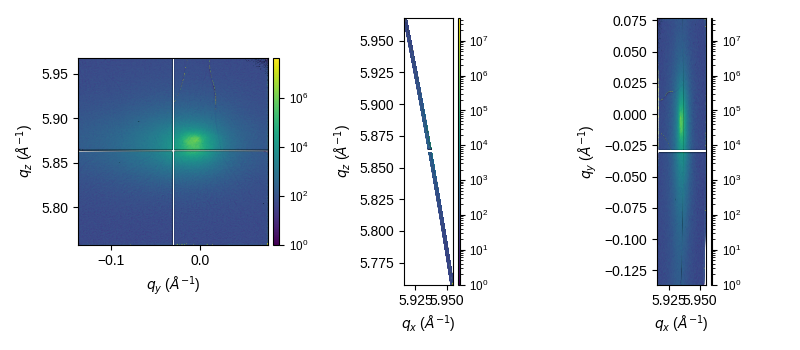

In [87]:
fig, ax = plt.subplots(1,3,figsize=(8,3.5), dpi=100)

ax[0].pcolormesh(qy, qz, fint, norm=LogNorm(), shading='gouraud')
ax[1].pcolormesh(qx, qz, fint, norm=LogNorm(), shading='gouraud')
ax[2].pcolormesh(qx, qy, fint, norm=LogNorm(), shading='gouraud')

[ax[i].set_ylabel(r'$q_z$ ($\AA^{-1}$)') for i in (0,1)]
[ax[i].set_xlabel(r'$q_x$ ($\AA^{-1}$)') for i in (1,2)]

ax[0].set_xlabel(r'$q_y$ ($\AA^{-1}$)')
ax[2].set_ylabel(r'$q_y$ ($\AA^{-1}$)')

for a in ax:
    a.set_aspect('equal')
    sxdm.plot.add_colorbar(a, a.get_children()[0])
    
fig.tight_layout()

/tmp/ipykernel_2800739/404654738.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(layout='tight')


Text(0.5, 0, '$q_z~(\\AA^{-1})$')

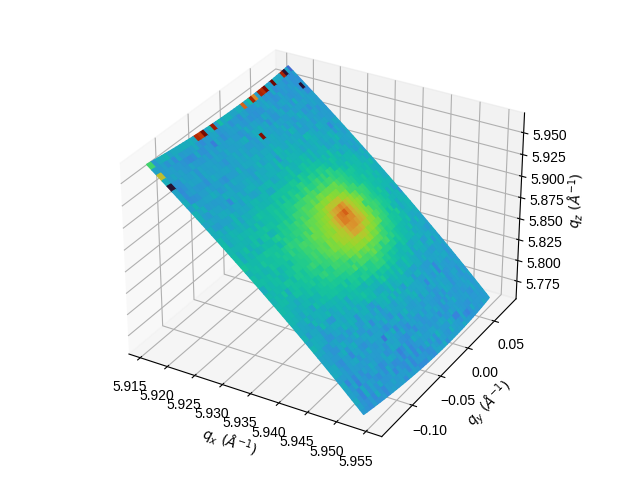

In [88]:
color_map = plt.get_cmap('turbo')

ffint = fint.astype(np.float64)
ffint = np.log(ffint)
ffint /= ffint.max()

I = color_map(ffint)

fig = plt.figure(layout='tight')
ax = fig.add_subplot(projection='3d')

ax.plot_surface(qx, qy, qz, facecolors=I)

ax.set_xlabel(r'$q_x~(\AA^{-1})$')
ax.set_ylabel(r'$q_y~(\AA^{-1})$')
ax.set_zlabel(r'$q_z~(\AA^{-1})$')

In [97]:
# %time coms = sxdm.process.math.calc_coms_qspace2d(path_dset, '8.1', qx, qy, qz, detector='mpxgaas', mask_rec=mask)
%time coms = sxdm.process.math.calc_coms_qspace2d(path_dset, '1.1', qx, qy, qz)

CPU times: user 374 ms, sys: 926 ms, total: 1.3 s
Wall time: 3 s


In [99]:
map_sh = sxdm.io.bliss.get_scan_shape(path_dset, '1.1')

coms = coms.reshape(*map_sh, 3)

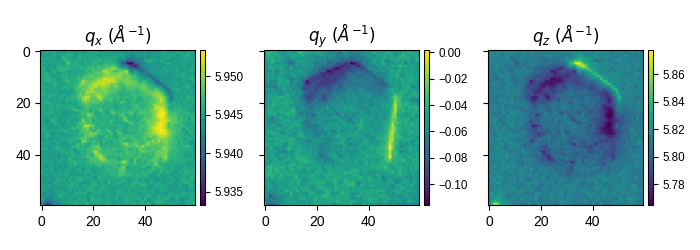

In [100]:
titles = ['$q_x~(\AA^{-1})$', '$q_y~(\AA^{-1})$', '$q_z~(\AA^{-1})$']

fig, ax = plt.subplots(1,3, layout='tight', sharey=True, figsize=(7,2.5))

for i, t in zip(range(3), titles):
    im = ax[i].imshow(coms[...,i])
    cbar = sxdm.plot.add_colorbar(ax[i], im)
    
    ax[i].set_title(t)

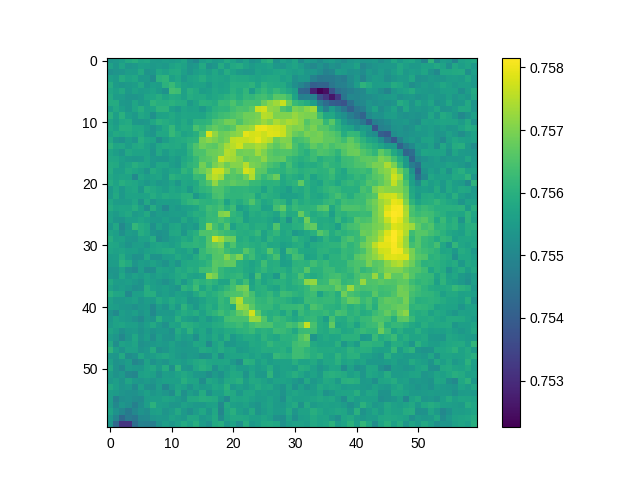

In [106]:
plt.figure()
plt.imshow(2*np.pi / np.linalg.norm(coms, axis=2))
plt.colorbar()